# 1.  Imports

In [1]:
# generics
import pandas as pd
import numpy as np
import random

# visu
#import seaborn as sns
import matplotlib.pyplot as plt
#from wordcloud import WordCloud

# texts
import re
import unicodedata
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

# Model
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics

/.autofs/tools/spack/var/spack/environments/reu-sep-21062801/.spack-env/view/lib/python3.8/site-packages/jmespath/visitor.py:32: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if x is 0 or x is 1:
/.autofs/tools/spack/var/spack/environments/reu-sep-21062801/.spack-env/view/lib/python3.8/site-packages/jmespath/visitor.py:32: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if x is 0 or x is 1:
/.autofs/tools/spack/var/spack/environments/reu-sep-21062801/.spack-env/view/lib/python3.8/site-packages/jmespath/visitor.py:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif y is 0 or y is 1:
/.autofs/tools/spack/var/spack/environments/reu-sep-21062801/.spack-env/view/lib/python3.8/site-packages/jmespath/visitor.py:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif y is 0 or y is 1:
/.autofs/tools/spack/var/spack/environments/reu-sep-21062801/.spack-env/view/lib/python3.8/site-packages/jmespath/visitor.py:260: SyntaxWarning: "is" with a literal. Di

# 2.  Loading data

In [2]:
df_train = pd.read_csv("./Data/Corona_NLP_train.csv", encoding="latin_1")
df_test = pd.read_csv("./Data/Corona_NLP_test.csv", encoding="latin_1")

# 3.  Data overview

In [3]:
df_train.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
7519,11318,56270,"New York, NY",19-03-2020,Minnesota has classified grocery store workers...,Positive
35730,39529,84481,"Cambridge, UK",09-04-2020,Unconfirmed location South Africa desperate hu...,Negative
34635,38434,83386,NaN,08-04-2020,Trends in connected health are rapidly acceler...,Positive
20327,24126,69078,"Birmingham, Birmingham",24-03-2020,These bastards are mocking it ..bumping up pri...,Extremely Negative
30230,34029,78981,India,06-04-2020,India loses out on rice export dollars\r\r\nLo...,Extremely Positive


In [4]:
max_tweet_length = 0
tweet_length = []
#
for tweet in df_train["OriginalTweet"]:
    tweet_length.append(len(tweet))
    if len(tweet) > max_tweet_length:
        max_tweet_length = len(tweet)
print("Longest tweet: " + str(max_tweet_length) + " characters")

Longest tweet: 355 characters


In [5]:
temp = df_train.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Sentiment,OriginalTweet
4,Positive,11422
2,Negative,9917
3,Neutral,7713
1,Extremely Positive,6624
0,Extremely Negative,5481


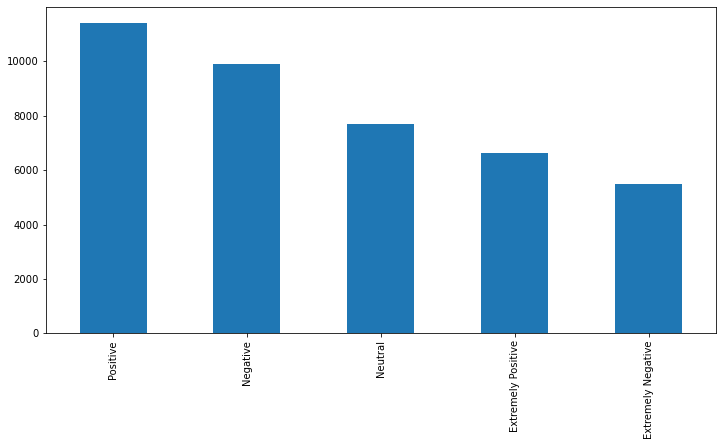

In [6]:
plt.figure(figsize=(12,6))
df_train['Sentiment'].value_counts().plot.bar()
plt.show()

In [7]:
class_df = df_train.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
class_df.style.background_gradient(cmap='winter')

,Sentiment,OriginalTweet
4,Positive,11422
2,Negative,9917
3,Neutral,7713
1,Extremely Positive,6624
0,Extremely Negative,5481


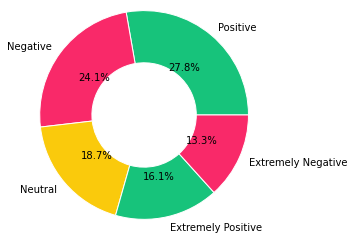

In [8]:
percent_class=class_df.OriginalTweet
labels= class_df.Sentiment

colors = ['#17C37B','#F92969','#FACA0C']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white') 

plt.show()

# 4.  Turning 5 categories into 3 categories
Here we convert <b>extremely positive</b> tweets into <b style="color: green">positive</b> and <b>extremely negative</b> tweets into <b style="color: red">negative</b>.

In [9]:
def set_3_classes(x):
    if x=="Extremely Negative":
        return "Negative"
    elif x=="Extremely Positive":
        return "Positive"
    else:
        return x

In [10]:
df_train["Sentiment"] = df_train["Sentiment"].apply(set_3_classes)
df_test["Sentiment"] = df_test["Sentiment"].apply(set_3_classes)

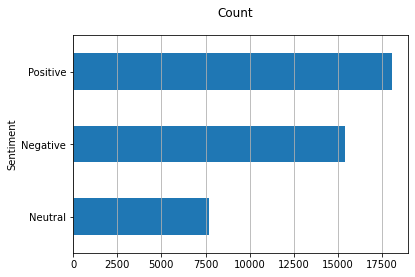

In [11]:
fig, ax = plt.subplots()
fig.suptitle("Count", fontsize=12)
df_train["Sentiment"].reset_index().groupby("Sentiment").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [12]:
class_df = df_train.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
class_df.style.background_gradient(cmap='winter')

,Sentiment,OriginalTweet
2,Positive,18046
0,Negative,15398
1,Neutral,7713


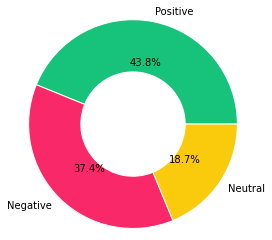

In [13]:
percent_class=class_df.OriginalTweet
labels= class_df.Sentiment

colors = ['#17C37B','#F92969','#FACA0C']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white') 

plt.show()

# 5. Cleaning tweets

In [14]:
df_train["CleanTweet"] = df_train["OriginalTweet"]
df_train.sample(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanTweet
5498,9297,54249,Jersey girl. Fuhgeddaboutit!,19-03-2020,Paramedics struggling to get food as UK panic ...,Negative,Paramedics struggling to get food as UK panic ...
12830,16629,61581,"Washington, DC",21-03-2020,Lol at Verizon sending me an email about how t...,Positive,Lol at Verizon sending me an email about how t...
13160,16959,61911,2x as far from middle to there,21-03-2020,You just know the same cunts that moaned about...,Negative,You just know the same cunts that moaned about...


<b>Removing end-of-line, tabulation and carriage return. Turning into lower case:</b>

In [15]:
def clean_eol_tabs(df, label):
    """ text lowercase
        removes \n
        removes \t
        removes \r """
    df[label] = df[label].str.lower()
    df[label] = df[label].apply(lambda x: x.replace("\n", " "))
    df[label] = df[label].apply(lambda x: x.replace("\r", " "))
    df[label] = df[label].apply(lambda x: x.replace("\t", " "))
    return df
#
df_train = clean_eol_tabs(df_train, "CleanTweet")

<b>Removing e-mails:</b>

In [16]:
def remove_emails(df, label):
    """ This function removes email adresses
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])""", " ", x))
    return df
#
df_train = remove_emails(df_train, "CleanTweet")

<b>Removing mentions:</b>

In [17]:
def remove_mentions(df, label):
    """ This function removes mentions (Twitter - starting with @) from texts
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"@([a-zA-Z0-9_.-]{1,100})", " ", x))
    return df
#
df_train = remove_mentions(df_train, "CleanTweet")

<b>Removing hyperlinks:</b>

In [18]:
def remove_hyperlinks(df, label):
    """ This function removes hyperlinks from texts
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"http\S+", " ", x))
    return df
#
df_train = remove_hyperlinks(df_train, "CleanTweet")

<b>Removing hashtags:</b>

In [19]:
def remove_hashtags(df, label):
    """ This function removes hashtags
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"#\w+", " ", x))
    return df
#
df_train = remove_hashtags(df_train, "CleanTweet")

<b>Removing html tags:</b>

In [20]:
def remove_html_tags(df, label):
    """ This function removes html tags from texts
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"<.*?>", " ", x))
    return df
#
df_train = remove_html_tags(df_train, "CleanTweet")

<b>Removing numbers:</b>

In [21]:
def remove_numbers(df, label):
    """ This function removes numbers from a text
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"\d+", " ", x))
    return df
#
df_train = remove_numbers(df_train, "CleanTweet")

<b>Encode unknown characters:</b>

In [22]:
def encode_unknown(df, label):
    """ This function encodes special caracters """
    df[label] = df[label].apply(lambda x: unicodedata.normalize("NFD", x).encode('ascii', 'ignore').decode("utf-8"))
    return df
#
df_train = encode_unknown(df_train, "CleanTweet")

<b>Removing punctuations and special characters:</b><br>
*Note this function will remove punctuation AND accented characters. Thus it is not necessary usable on languages that have accented characters. But for english it is ok.*

In [23]:
def clean_punctuation_no_accent(df, label):
    """ This function removes punctuation and accented characters from texts in a dataframe 
        To be appplied to languages that have no accents, ex: english 
    """
    df[label] = df[label].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    return df
#
df_train = clean_punctuation_no_accent(df_train, "CleanTweet")

<b>Removing stop words. Here, the list is from nltk stopwords library:</b>

In [24]:
def remove_stop_words(text, stopwords=set(stopwords.words('english'))):
    """ This function removes stop words from a text
        inputs:
         - stopword list
         - text """

    # prepare new text
    text_splitted = text.split(" ")
    text_new = list()
    
    # stop words updated
    #stopwords = stopwords.union({"amp", "grocery store", "covid", "supermarket", "people", "grocery", "store", "price", "time", "consumer"})
    
    # loop
    for word in text_splitted:
        if word not in stopwords:
            text_new.append(word)
    return " ".join(text_new)

def clean_stopwords(df, label):
    """ This function removes stopwords """
    df[label] = df[label].apply(lambda x: remove_stop_words(x))
    return df
#
df_train = clean_stopwords(df_train, "CleanTweet")

<b>Removing one and two letters words, removing unnecessary spaces, droping empty lines:</b>

In [25]:
def more_cleaning(df, label):
    """ This function
     1) removes remaining one-letter words and two letters words
     2) replaces multiple spaces by one single space
     3) drop empty lines """
    df[label] = df[label].apply(lambda x: re.sub(r'\b\w{1,2}\b', " ", x))
    df[label] = df[label].apply(lambda x: re.sub(r"[ \t]{2,}", " ", x))
    df[label] = df[label].apply(lambda x: x if len(x) != 1 else '')
    df[label] = df[label].apply(lambda x: np.nan if x == '' else x)
    df = df.dropna(subset=[label], axis=0).reset_index(drop=True).copy()
    return df
#
df_train = more_cleaning(df_train, "CleanTweet")

<b>Lemmatizing words:</b><br>
*Note: Here the lemmatizer works only for its default parameter which is <b>nouns</b>. That is to say, it will only find the closest root for nouns and will not work on verbs or adjectives ect ... I tried with lemmatization of everything but the accuracy was lower*

In [26]:
def lemmatize_one_text(text):
    """ This function lemmatizes words in text (it changes word to most close root word)
        inputs:
         - lemmatizer
         - text """

    # initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # tags
    lem_tags = ['a', 'r', 'n', 'v']

    # prepare new text
    text_splitted = text.split(" ")
    text_new = list()

    # change bool
    changed = ''
    
    # loop
    for word in text_splitted:
        text_new.append(lemmatizer.lemmatize(word))
        #changed = ''
        #for tag in lem_tags:
        #    if lemmatizer.lemmatize(word, tag) != word:
        #        changed = tag
        #if changed == '':
        #    text_new.append(word)
        #else:
        #    text_new.append(lemmatizer.lemmatize(word, changed))

    return " ".join(text_new)

def lemmatize(df, label):
    """ This function lemmatizes texts """
    df[label] = df[label].apply(lambda x: lemmatize_one_text(x))
    return df
#
df_train = lemmatize(df_train, "CleanTweet")

In [27]:
df_train.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanTweet
21064,24894,69846,"Norwalk, CT",25-03-2020,So proud of @RRRepellents and their work to he...,Positive,proud work help health crisis moved fast begin...
5409,9218,54170,"Los Angeles, CA",19-03-2020,@Brooklyn9_1_1 @scottgurvey @weijia @fema @US_...,Neutral,pin pad atm machine grocery store register di...
14277,18097,63049,South Africa,21-03-2020,President of Russia Vladimir Putin being asked...,Positive,president russia vladimir putin asked done com...
31156,34994,79946,"Sussex, UK",06-04-2020,#StayHomeSaveLives but how when you can't get ...,Neutral,get supermarket delivery slot
22332,26162,71114,United Kingdom,25-03-2020,#House prices expected to fall due to #COVID19...,Neutral,price expected fall due


### Let's apply all of these cleaning on test data set as well:

In [28]:
df_test["CleanTweet"] = df_test["OriginalTweet"]
df_test = clean_eol_tabs(df_test, "CleanTweet")
df_test = remove_emails(df_test, "CleanTweet")
df_test = remove_mentions(df_test, "CleanTweet")
df_test = remove_hyperlinks(df_test, "CleanTweet")
df_test = remove_hashtags(df_test, "CleanTweet")
df_test = remove_html_tags(df_test, "CleanTweet")
df_test = remove_numbers(df_test, "CleanTweet")
df_test = encode_unknown(df_test, "CleanTweet")
df_test = clean_punctuation_no_accent(df_test, "CleanTweet")
df_test = clean_stopwords(df_test, "CleanTweet")
df_test = more_cleaning(df_test, "CleanTweet")
df_test = lemmatize(df_test, "CleanTweet")

In [29]:
df_test.sample(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanTweet
939,940,45892,"Donegal, Ireland",12-03-2020,"All of Ireland on lockdown, all school/collage...",Negative,ireland lockdown school collage closed today e...
46,47,44999,"Colorado, USA",09-03-2020,I have instructed that insurance companies mak...,Positive,instructed insurance company make covid testin...
1534,1535,46487,Canada,13-03-2020,"Hey everyone, donÂt forget to check your pets...",Negative,hey everyone donat forget check pet food suppl...


### Let's have a look on before/after cleaning on several tweets:

In [30]:
tweet_num = random.randint(0, df_train.shape[0])
print("############################# Original Tweet #############################")
print(df_train.iloc[tweet_num].at["OriginalTweet"])
print("\n")
print("############################# Clean Tweet ################################")
print(df_train.iloc[tweet_num].at["CleanTweet"])

############################# Original Tweet #############################
We are so pleased to be able to help local aldershot resident David UK Man 70 was living solely on Domino s pizza Daily Mail Online


############################# Clean Tweet ################################
pleased able help local aldershot resident david man living solely domino pizza daily mail online


In [31]:
tweet_num = random.randint(0, df_train.shape[0])
print("############################# Original Tweet #############################")
print(df_train.iloc[tweet_num].at["OriginalTweet"])
print("\n")
print("############################# Clean Tweet ################################")
print(df_train.iloc[tweet_num].at["CleanTweet"])

############################# Original Tweet #############################
@stacieco13 @CBSNews COVID-19 infecting entire teams of workers, the stress and pressure put on retail and food service workers to put out groceries and essentials in the face of panic buyers, the stress and pressure put on healthcare workers from increas


############################# Clean Tweet ################################
 covid infecting entire team worker stress pressure put retail food service worker put grocery essential face panic buyer stress pressure put healthcare worker increas


It looks good

# 6.  Looking at data

<b>Sentiment repartition:</b>

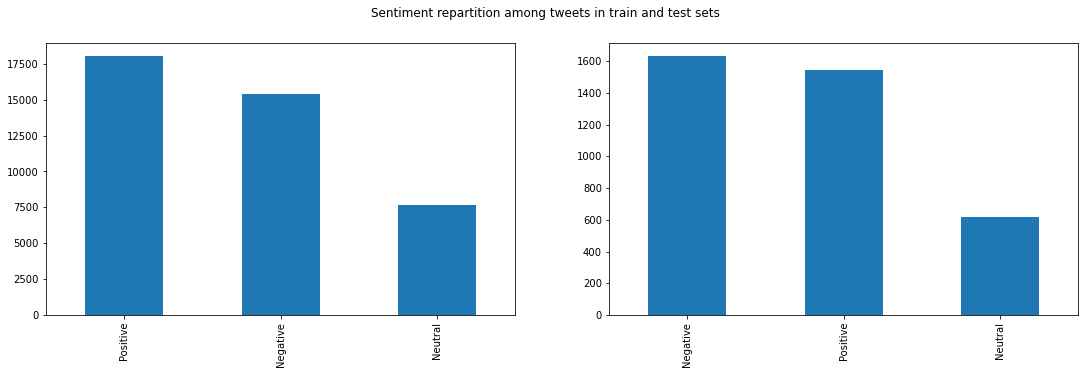

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5)
fig.suptitle('Sentiment repartition among tweets in train and test sets')
df_train["Sentiment"].value_counts().plot(kind="bar", ax=ax1);
df_test["Sentiment"].value_counts().plot(kind="bar", ax=ax2);

<b>Word cloud in each sentiment categories:</b>

In [33]:
# all_words_positive = " ".join([text for text in df_train[df_train["Sentiment"]=="Positive"]["CleanTweet"]])
# all_words_neutral = " ".join([text for text in df_train[df_train["Sentiment"]=="Neutral"]["CleanTweet"]])
# all_words_negative = " ".join([text for text in df_train[df_train["Sentiment"]=="Negative"]["CleanTweet"]])

In [34]:
# wordcloud_positive = WordCloud(width=800, height=600, max_font_size=120, background_color="white", colormap="Greens").generate(all_words_positive)
# wordcloud_neutral = WordCloud(width=800, height=600, max_font_size=120, background_color="white", colormap="YlOrBr").generate(all_words_neutral)
# wordcloud_negative = WordCloud(width=800, height=600, max_font_size=120, background_color="white", colormap="Reds").generate(all_words_negative)

In [35]:
# parameters = {'axes.labelsize': 12,
#               'axes.titlesize': 10}
# #
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# fig.set_size_inches(18.5, 7)
# ax1.imshow(wordcloud_positive, interpolation='bilinear')
# ax1.axis("off")
# ax1.set_title("WordCloud of positive tweets", fontsize=12)
# ax2.imshow(wordcloud_neutral, interpolation='bilinear')
# ax2.axis("off")
# ax2.set_title("WordCloud of neutral tweets", fontsize=12)
# ax3.imshow(wordcloud_negative, interpolation='bilinear')
# ax3.axis("off")
# ax3.set_title("WordCloud of negative tweets", fontsize=12)
# plt.rcParams.update(parameters)
# plt.show()

# 7. Sentiment encoding

In [36]:
df_train_encoded = df_train.copy()
df_test_encoded = df_test.copy()
#
print("train set shape: " + str(df_train_encoded.shape))
print("test set shape: " + str(df_test_encoded.shape))

train set shape: (41100, 7)
test set shape: (3795, 7)


In [37]:
map_sentiment = {"Neutral":0, "Positive":1,"Negative":2}
df_train_encoded['Sentiment'] = df_train_encoded['Sentiment'].map(map_sentiment)
df_test_encoded['Sentiment']  = df_test_encoded['Sentiment'].map(map_sentiment)

# 8. Feature and target preparation

In [38]:
y_train = df_train['Sentiment'].copy()
y_test = df_test['Sentiment'].copy()
#
y_train_encoded = to_categorical(df_train_encoded['Sentiment'], 3)
y_test_encoded = to_categorical(df_test_encoded['Sentiment'], 3)
#
y_train_mapped = df_train_encoded['Sentiment'].copy()
y_test_mapped = df_test_encoded['Sentiment'].copy()
#
X_train = df_train_encoded[['CleanTweet']].copy()
X_test = df_test_encoded[['CleanTweet']].copy()

# 9. Tokenization, sequences, padding

<b>The result of tokenizer is a dictionnary with:</b><br>
* key = word<br>
* value = unique number

In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train["CleanTweet"])
vocab_length = len(tokenizer.word_index) + 1
vocab_length

30445

The <b>texts_to_sequences</b> function first transforms a text into list of words. Then, thanks to the dictionnary previously created by the tokenizer (see above), transforms list of list of words into list of list of numbers

In [40]:
X_train = tokenizer.texts_to_sequences(X_train["CleanTweet"])
X_test = tokenizer.texts_to_sequences(X_test["CleanTweet"])

Each tweets has differents length. Thus the result of the <b>texts_to_sequences</b> function will be a list of list of numbers of different length: 

In [41]:
print("First tweet encoded:")
print(X_train[0])
print("\nSecond tweet encoded:")
print(X_train[1])
print("\nThird tweet encoded:")
print(X_train[2])

First tweet encoded:
[387, 492, 1463, 96, 2123, 605, 260, 911, 303, 257, 605, 260, 1463, 352, 1620, 1892, 341, 11, 10, 781, 4020, 2618, 27, 854, 1977, 91]

Second tweet encoded:
[23, 769, 3734, 173, 220, 1235, 1526, 10, 105, 87, 1, 65]

Third tweet encoded:
[5, 25, 26, 133, 36, 18, 156, 5, 74, 59, 12, 45, 812, 45, 90]


To feed the deep learning model, we need all these lists to be the same length. Thus we need to apply padding. In other words, we are going to add several zeros (0) at the end of the shortest tweets so that at the end, all of our lists have the same length. <br><br>
First let's get the maximum number of words in one tweet:

In [42]:
max_word_count = 0
word_count = []
#
for encoded_tweet in X_train:
    word_count.append(len(encoded_tweet))
    if len(encoded_tweet) > max_word_count:
        max_word_count = len(encoded_tweet)
print("Maximum number of word in one tweet: " + str(max_word_count) + " words")

Maximum number of word in one tweet: 37 words


So the longest tweet we have is composed of 37 words. We are going to pad the sequences with a maximum length of 37.

In [43]:
X_train = pad_sequences(X_train, maxlen=max_word_count, padding='post')
X_test = pad_sequences(X_test, maxlen=max_word_count, padding='post')
X_train.shape

(41100, 37)

Let's have a look at the encoded 3 tweets after padding:

In [44]:
print("First tweet encoded:", "Size = ", len(X_train[0]))
print(X_train[0])
print("\nSecond tweet encoded:", "Size = ", len(X_train[1]))
print(X_train[1])
print("\nThird tweet encoded:", "Size = ", len(X_train[2]))
print(X_train[2])

First tweet encoded: Size =  37
[ 387  492 1463   96 2123  605  260  911  303  257  605  260 1463  352
 1620 1892  341   11   10  781 4020 2618   27  854 1977   91    0    0
    0    0    0    0    0    0    0    0    0]

Second tweet encoded: Size =  37
[  23  769 3734  173  220 1235 1526   10  105   87    1   65    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]

Third tweet encoded: Size =  37
[  5  25  26 133  36  18 156   5  74  59  12  45 812  45  90   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]


Now every encoded tweet has the same length, the data is ready for the model.

# 10. Model

<b>The model is composed of:</b>
1. <b>An embedding layer with parameters</b>
    * input dim = vocabulary size
    * output dim = 32
    * input length = size of padded sequences
    * mask_zero = True to ignore 0 (from padding)
2. <b>An LSTM (Long Short Term Memory) Layer with parameter</b>
    * units = 100 (the resulting accuracy is almost the same regardless this value)
3. <b>Three Dense layers</b>
4. <b>An output dense layer with parameters</b>
    * units = 3 (output dim)
    * activation = softmax (for multiclassification problem)

<b>Compilation with parameters:</b>
1. loss = categorical_crossentropy (for multiclassification problem)
2. optimizer = adam
3. metrics = accuracy

In [45]:
model_LSTM = Sequential()
model_LSTM.add(layers.Embedding(vocab_length, output_dim=32, input_length=max_word_count, mask_zero=True))
model_LSTM.add(layers.LSTM(100))
model_LSTM.add(layers.Dense(64, activation="relu"))
model_LSTM.add(layers.Dense(32, activation="relu"))
model_LSTM.add(layers.Dense(16, activation="relu"))
model_LSTM.add(layers.Dense(3, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_LSTM.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 37, 32)            974240    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 1,036,563
Trainable params: 1,036,563
Non-trainable params: 0
______________________________________________

Here I set an early stopping after 10 epochs and set the parameter <i><b>restore_best_weights</b></i> to <b style="color:green">True</b> so that the weights of best score on monitored metric - here <b>val_accuracy</b> (accuracy on test set) - are restored when training stops. This way the model has the best accuracy possible on unseen data.

In [46]:
es = EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True)
history = model_LSTM.fit(X_train,
                         y_train_encoded,
                         validation_data=(X_test, y_test_encoded),
                         epochs=30,
                         batch_size=16,
                         verbose=1,
                         callbacks=[es]
                        )

Epoch 1/30
2569/2569 [==============================] - 69s 25ms/step - loss: 0.8057 - accuracy: 0.6059 - val_loss: 0.4534 - val_accuracy: 0.8448
Epoch 2/30
2569/2569 [==============================] - 62s 24ms/step - loss: 0.3252 - accuracy: 0.8940 - val_loss: 0.4522 - val_accuracy: 0.8408
Epoch 3/30
2569/2569 [==============================] - 62s 24ms/step - loss: 0.2227 - accuracy: 0.9301 - val_loss: 0.4865 - val_accuracy: 0.8393
Epoch 4/30
2569/2569 [==============================] - 62s 24ms/step - loss: 0.1729 - accuracy: 0.9447 - val_loss: 0.5881 - val_accuracy: 0.8311
Epoch 5/30
2569/2569 [==============================] - 61s 24ms/step - loss: 0.1258 - accuracy: 0.9575 - val_loss: 0.6711 - val_accuracy: 0.8237
Epoch 6/30
2569/2569 [==============================] - 61s 24ms/step - loss: 0.0963 - accuracy: 0.9675 - val_loss: 0.7456 - val_accuracy: 0.8208
Epoch 7/30
2569/2569 [==============================] - 62s 24ms/step - loss: 0.0688 - accuracy: 0.9768 - val_loss: 0.8396 -

We can see that after epoch 2, the accuracy on test set - val_accuracy - doesn't increase any more while accuracy on train set continues to increase untill almost 100%! The model is overfitting from epoch 2 and is not able to generalize well on unseen data from there.

# 11. Model Evaluation

<b>Prediction on test set:</b>

In [53]:
predicted = model_LSTM.predict(X_test)
y_pred = predicted.argmax(axis=-1)

<b>Calculation of accuracy and Area Under (ROC) Curve - AUC - scores:</b>

In [54]:
acc_score = accuracy_score(y_test_mapped, y_pred)
auc_score = roc_auc_score(y_test_mapped, predicted, multi_class="ovr")

<b>Classification report:</b>

In [55]:
report = classification_report(y_test_mapped, y_pred, target_names=list(y_test.unique()), output_dict=True)

accuracy_col = ([""]*3) + [round(acc_score, 2)]
roc_auc_col = ([""]*3) + [round(auc_score, 2)]
accuracy_col = pd.Series(accuracy_col, index=list(report["Neutral"].keys()))
roc_auc_col = pd.Series(roc_auc_col, index=list(report["Neutral"].keys()))
df_report = pd.DataFrame(report)[["Neutral", "Positive", "Negative", "macro avg", "weighted avg"]].apply(lambda x: round(x, 2))
df_report["accuracy"] = accuracy_col
df_report["roc_auc"] = roc_auc_col
df_report

,Neutral,Positive,Negative,macro avg,weighted avg,accuracy,roc_auc
precision,0.88,0.83,0.8,0.84,0.85,,
recall,0.82,0.89,0.8,0.84,0.84,,
f1-score,0.85,0.86,0.8,0.84,0.84,,
support,1633.00,1546.00,616.0,3795.00,3795.00,0.84,0.94


<b>Confusion Matrix:</b>

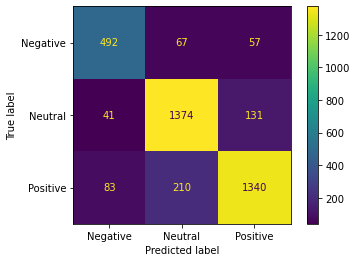

In [56]:
cm = confusion_matrix(y_test_mapped, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(y_test))
disp.plot()
plt.show()

<b>ROC and precision-recall curves</b>

In [57]:
y_test_array = pd.get_dummies(y_test_mapped, drop_first=False).values
classes = y_train.unique()

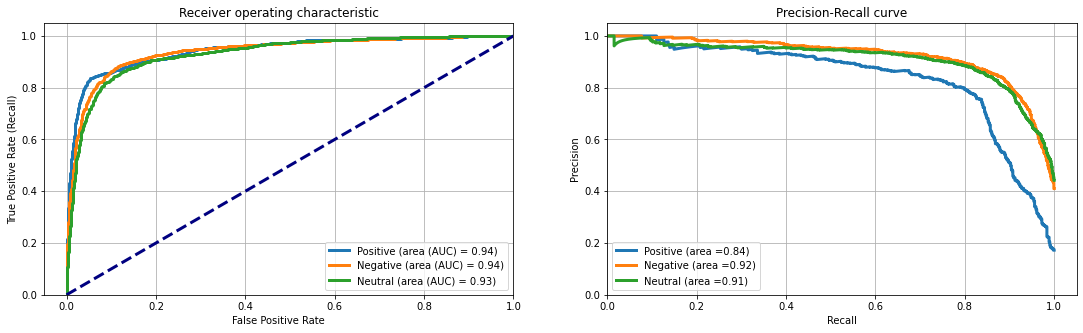

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18.5, 5)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i], predicted[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area (AUC) = {1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area ={1:0.2f})'.format(classes[i], metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()